In [21]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNEL=3
EPOCHS=12

In [22]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [23]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

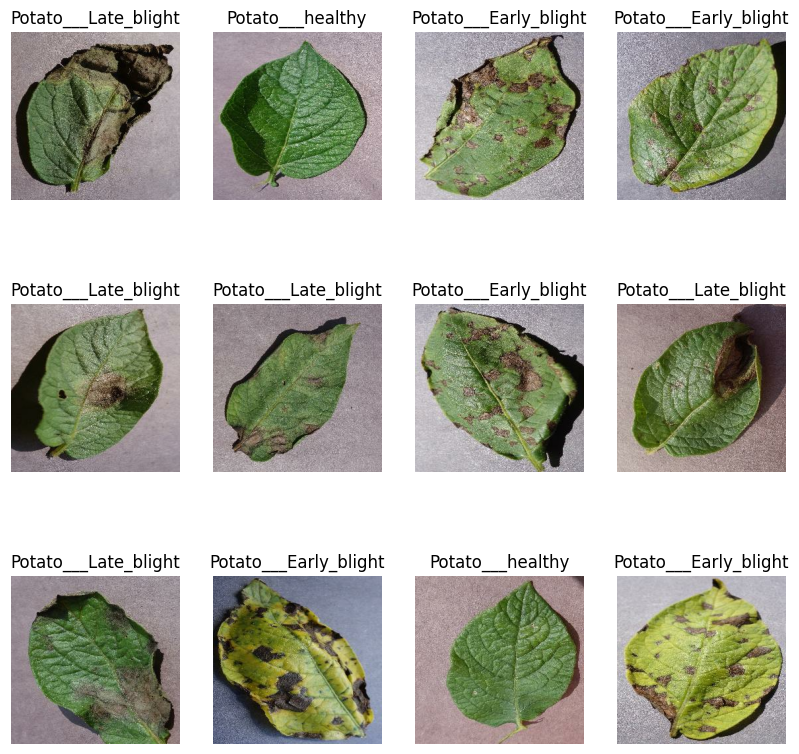

In [24]:
plt.figure(figsize=(10, 10))
for image_batch,label_batch in dataset.take(1):
    #print(image_batch[0].shape)
    #print(image_batch[0].numpy())
    #print(label_batch.numpy())
    #print(label_batch[0].numpy())
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [25]:
#function to split dataset
# we will divide dataset into 3 parts.
# 1.Training: Dataset to be used while training
# 2.Validation: Dataset to be tested against while training
# 3.Test: Dataset to be tested against after we trained a model

In [26]:
len(dataset)

68

In [27]:
# stratified sampleling
#cross validation
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [28]:
train_ds = dataset.take(54)

In [29]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [30]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [31]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [32]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [33]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [34]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [35]:
len(train_ds)

54

In [36]:
len(val_ds)

6

In [37]:
len(test_ds)

8

In [38]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [39]:
#resize the image into (256,256) because when we are done with the training and start using the model for predictions. 
#At that time someone can supply an image that is not (256,256) and this layer will resize it.
#To improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). 
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [40]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [41]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [42]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [43]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/12
54/54 [==============================] - 134s 2s/step - loss: 0.9096 - accuracy: 0.4925 - val_loss: 0.8646 - val_accuracy: 0.4635
Epoch 2/12
54/54 [==============================] - 118s 2s/step - loss: 0.7371 - accuracy: 0.6175 - val_loss: 0.5714 - val_accuracy: 0.7188
Epoch 3/12
54/54 [==============================] - 121s 2s/step - loss: 0.5067 - accuracy: 0.7795 - val_loss: 0.4228 - val_accuracy: 0.7969
Epoch 4/12
54/54 [==============================] - 111s 2s/step - loss: 0.3535 - accuracy: 0.8519 - val_loss: 0.3182 - val_accuracy: 0.8958
Epoch 5/12
54/54 [==============================] - 110s 2s/step - loss: 0.3242 - accuracy: 0.8617 - val_loss: 0.2656 - val_accuracy: 0.8958
Epoch 6/12
54/54 [==============================] - 109s 2s/step - loss: 0.1984 - accuracy: 0.9184 - val_loss: 0.1581 - val_accuracy: 0.9583
Epoch 7/12
54/54 [==============================] - 105s 2s/step - loss: 0.1668 - accuracy: 0.9433 - val_loss: 0.2278 - val_accuracy: 0.9219
Epoch 8/12
54

In [25]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 7s 560ms/step - loss: 0.0635 - accuracy: 0.9844


In [26]:
history.params

{'verbose': 1, 'epochs': 12, 'steps': 54}

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9096246361732483,
 0.737139105796814,
 0.5067455768585205,
 0.35353952646255493,
 0.32424551248550415]

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

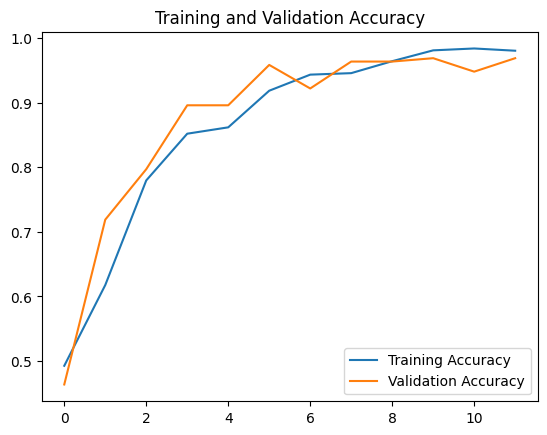

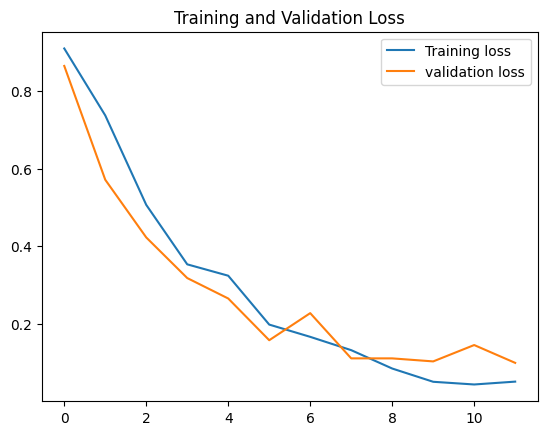

In [30]:
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='validation loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

actual label: Potato___Early_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Early_blight


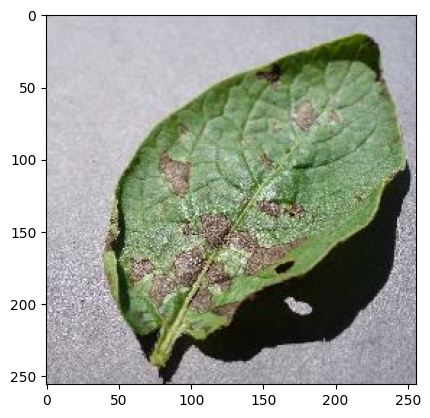

In [31]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

1/1 [==============================] - 1s 603ms/step


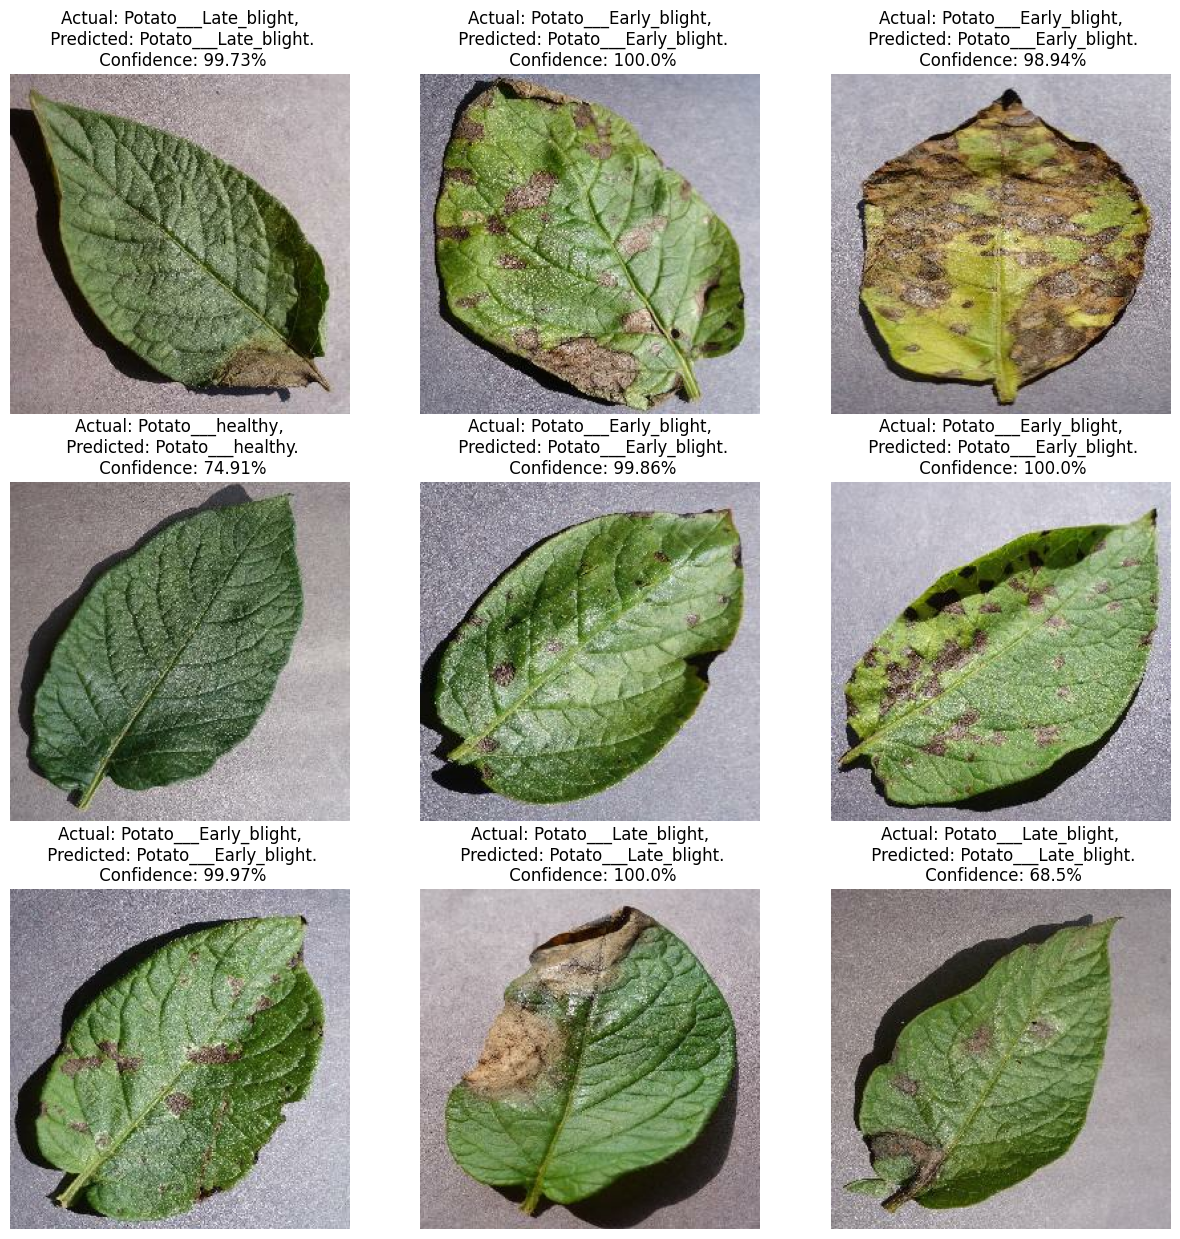

In [32]:
plt.figure(figsize=(15, 15))
for images_batch, labels_batch in test_ds.take(1):
    for i in range(9):
        image = images_batch[i].numpy().astype('uint8')
        label = labels_batch[i].numpy()
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        actual_class=class_names[label]
        batch_prediction = model.predict(images_batch)
        predicted_class=class_names[np.argmax(batch_prediction[i])]
        confidence = round(100 * (np.max(batch_prediction[i])), 2)
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [33]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [33]:
import os
model_version= max([int(i) for i in os.listdir("../models")+[0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets
